In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging
import multiprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp

import arviz as az
import numpyro
import numpyro.distributions as dist

from hbmep.config import Config
from hbmep.model import BaseModel
from hbmep.model import functional as F
from hbmep.model.utils import Site as site
from hbmep.utils import timing

from hbmep_paper.utils import load_intraoperative_data

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)


In [2]:
class MixtureModel(BaseModel):
    LINK = "mixture_model"

    def __init__(self, config: Config):
        super(MixtureModel, self).__init__(config=config)

    def _model(self, features, intensity, response_obs=None):
        features, n_features = features
        intensity, n_data = intensity
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)
        feature1 = features[1].reshape(-1,)
        feature2 = features[2].reshape(-1,)

        """ Global Priors """
        b_scale_global_scale = numpyro.sample("b_scale_global_scale", dist.HalfNormal(1))
        v_scale_global_scale = numpyro.sample("v_scale_global_scale", dist.HalfNormal(1))

        L_scale_global_scale = numpyro.sample("L_scale_global_scale", dist.HalfNormal(.5))
        ell_scale_global_scale = numpyro.sample("ell_scale_global_scale", dist.HalfNormal(100))
        H_scale_global_scale = numpyro.sample("H_scale_global_scale", dist.HalfNormal(5))

        g_1_scale_global_scale = numpyro.sample("g_1_scale_global_scale", dist.HalfNormal(100))
        g_2_scale_global_scale = numpyro.sample("g_2_scale_global_scale", dist.HalfNormal(100))

        with numpyro.plate(site.n_response, self.n_response):
            a_mean = numpyro.sample("a_mean", dist.TruncatedNormal(5, 10, low=0))
            a_scale = numpyro.sample("a_scale", dist.HalfNormal(10.0))

            b_scale_raw = numpyro.sample("b_scale_raw", dist.HalfNormal(scale=1))
            b_scale = numpyro.deterministic("b_scale", jnp.multiply(b_scale_global_scale, b_scale_raw))

            v_scale_raw = numpyro.sample("v_scale_raw", dist.HalfNormal(scale=1))
            v_scale = numpyro.deterministic("v_scale", jnp.multiply(v_scale_global_scale, v_scale_raw))

            L_scale_raw = numpyro.sample("L_scale_raw", dist.HalfNormal(scale=1))
            L_scale = numpyro.deterministic("L_scale", jnp.multiply(L_scale_global_scale, L_scale_raw))

            ell_scale_raw = numpyro.sample("ell_scale_raw", dist.HalfNormal(scale=1))
            ell_scale = numpyro.deterministic("sigma_ell", jnp.multiply(ell_scale_global_scale, ell_scale_raw))

            H_scale_raw = numpyro.sample("H_scale_raw", dist.HalfNormal(scale=1))
            H_scale = numpyro.deterministic("H_scale", jnp.multiply(H_scale_global_scale, H_scale_raw))

            g_1_scale_raw = numpyro.sample("g_1_scale_raw", dist.HalfNormal(scale=1))
            g_1_scale = numpyro.deterministic("g_1_scale", jnp.multiply(g_1_scale_global_scale, g_1_scale_raw))

            g_2_scale_raw = numpyro.sample("g_2_scale_raw", dist.HalfNormal(scale=1))
            g_2_scale = numpyro.deterministic("g_2_scale", jnp.multiply(g_2_scale_global_scale, g_2_scale_raw))

            with numpyro.plate(site.n_features[2], n_features[2]):
                with numpyro.plate(site.n_features[1], n_features[1]):
                    with numpyro.plate(site.n_features[0], n_features[0]):
                        """ Priors """
                        a = numpyro.sample("a", dist.TruncatedNormal(a_mean, a_scale, low=0))

                        b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                        b = numpyro.deterministic(site.b, jnp.multiply(b_scale, b_raw))

                        v_raw = numpyro.sample("v_raw", dist.HalfNormal(scale=1))
                        v = numpyro.deterministic(site.v, jnp.multiply(v_scale, v_raw))

                        L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                        L = numpyro.deterministic(site.L, jnp.multiply(L_scale, L_raw))

                        ell_raw = numpyro.sample("ell_raw", dist.HalfNormal(scale=1))
                        ell = numpyro.deterministic(site.ell, jnp.multiply(ell_scale, ell_raw))

                        H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
                        H = numpyro.deterministic(site.H, jnp.multiply(H_scale, H_raw))

                        g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                        g_1 = numpyro.deterministic(site.g_1, jnp.multiply(g_1_scale, g_1_raw))

                        g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                        g_2 = numpyro.deterministic(site.g_2, jnp.multiply(g_2_scale, g_2_raw))

        """ Outlier Distribution """
        outlier_prob = numpyro.sample("outlier_prob", dist.Uniform(0., .05))
        outlier_scale = numpyro.sample("outlier_scale", dist.HalfNormal(50))

        with numpyro.plate(site.n_response, self.n_response):
            with numpyro.plate(site.n_data, n_data):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    F.rectified_logistic(
                        x=intensity,
                        a=a[feature0, feature1, feature2],
                        b=b[feature0, feature1, feature2],
                        v=v[feature0, feature1, feature2],
                        L=L[feature0, feature1, feature2],
                        ell=ell[feature0, feature1, feature2],
                        H=H[feature0, feature1, feature2]
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[feature0, feature1, feature2] + jnp.true_divide(g_2[feature0, feature1, feature2], mu)
                )

                q = numpyro.deterministic("q", outlier_prob * jnp.ones((n_data, self.n_response)))
                bg_scale = numpyro.deterministic("bg_scale", outlier_scale * jnp.ones((n_data, self.n_response)))

                mixing_distribution = dist.Categorical(
                    probs=jnp.stack([1 - q, q], axis=-1)
                )
                component_distributions=[
                    dist.Gamma(concentration=jnp.multiply(mu, beta), rate=beta),
                    dist.HalfNormal(scale=bg_scale)
                ]

                """ Mixture """
                Mixture = dist.MixtureGeneral(
                    mixing_distribution=mixing_distribution,
                    component_distributions=component_distributions
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    Mixture,
                    obs=response_obs
                )

In [3]:
toml_path = "/home/vishu/repos/hbmep-paper/configs/paper/intraoperative/config.toml"
config = Config(toml_path=toml_path)
config.BUILD_DIR = os.path.join(config.BUILD_DIR, "subdural-epidural-new")
config.FEATURES = ["participant", "sc_depth", "sc_laterality"]
config.RESPONSE = ["Triceps", "APB", "ADM"]
config.MCMC_PARAMS["num_chains"] = 1
config.MCMC_PARAMS["num_warmup"] = 5000
config.MCMC_PARAMS["num_samples"] = 1000
model = MixtureModel(config=config)


2023-12-13 22:30:45,541 - hbmep.model.baseline - INFO - Initialized base_model


In [4]:
dir = "/home/vishu/data/"
sc_approach = "posterior"
df = load_intraoperative_data(dir=dir, sc_approach=sc_approach, subdural_epidural_only=True)
df[model.features[0]] = df[model.features[0]].replace({"epidural": "01_epidural", "subdural": "02_subdural"})
df[model.features[1]] = df[model.features[1]].replace({"R": "01_R", "M": "02_M"})
df, encoder_dict = model.load(df=df)
df.shape


2023-12-13 22:30:51,380 - hbmep.utils.utils - INFO - func:load_intraoperative_data took: 0.10 sec
2023-12-13 22:30:51,381 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/paper/intraoperative/subdural-epidural-new
2023-12-13 22:30:51,382 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/paper/intraoperative/subdural-epidural-new
2023-12-13 22:30:51,383 - hbmep.dataset.core - WARNING - Total non-positive observations: 0
2023-12-13 22:30:51,384 - hbmep.dataset.core - WARNING - Total missing observations: 0
2023-12-13 22:30:51,384 - hbmep.dataset.core - INFO - Processing data ...
2023-12-13 22:30:51,385 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


(188, 229)

In [5]:
src = '/home/vishu/repos/hbmep-paper/reports/paper/intraoperative/subdural-epidural-new/inference.pkl'
with open(src, "rb") as g:
    _, mcmc, posterior_samples = pickle.load(g)


In [7]:
_posterior_samples = posterior_samples.copy()
_posterior_samples["outlier_prob"] = _posterior_samples["outlier_prob"] * 0
prediction_df = model.make_prediction_dataset(df=df, num=500, min_intensity=0, max_intensity=8)
posterior_predictive = model.predict(df=prediction_df, posterior_samples=_posterior_samples)


2023-12-13 22:33:37,868 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec


2023-12-13 22:33:43,128 - hbmep.utils.utils - INFO - func:predict took: 5.26 sec


In [8]:
from numpyro.diagnostics import hpdi
mu = posterior_predictive[site.mu]
obs = posterior_predictive[site.obs]
a = posterior_samples[site.a]
obs_hpdi = hpdi(obs, prob=.95)
obs_hpdi.shape

(2, 2000, 3)

In [10]:
combinations = model._make_combinations(df=df, columns=model.features)
response_colors = {
    0: {
        0: (0.6706, 0.8510, 0.9137),
        1: (0.9451, 0.7137, 0.8549),
        2: (0.7216, 0.8824, 0.5255)
    },
    1: {
        0: (0.1725, 0.4824, 0.7137),
        1: (0.8157, 0.1098, 0.5451),
        2: (0.3020, 0.6745, 0.1490)
    }
}

In [12]:
a, b, L, ell, H, v = \
    np.array(posterior_samples[site.a]), \
    np.array(posterior_samples[site.b]), \
    np.array(posterior_samples[site.L]), \
    np.array(posterior_samples[site.ell]), \
    np.array(posterior_samples[site.H]), \
    np.array(posterior_samples[site.v])

a_map, b_map, L_map, ell_map, H_map, v_map = \
    a.mean(axis=0), \
    b.mean(axis=0), \
    L.mean(axis=0), \
    ell.mean(axis=0), \
    H.mean(axis=0), \
    v.mean(axis=0)


In [13]:
a_map = a.mean(axis=0)
a_map_offset = np.zeros(a_map.shape)

a_map_offset[0, 0, 0, 0] = -.12
a_map_offset[0, 0, 1, 0] = +.32

a_map_offset[0, 1, 0, 0] = -.28
a_map_offset[0, 1, 1, 0] = 0.

a_map_offset[0, 0, 0, 1] = 0
a_map_offset[0, 0, 1, 1] = +.24

a_map_offset[0, 1, 0, 1] = -.25
a_map_offset[0, 1, 1, 1] = -6.8

a_map_offset[0, 0, 0, 2] = +.64
a_map_offset[0, 0, 1, 2] = 0.

a_map_offset[0, 1, 0, 2] = -.22
a_map_offset[0, 1, 1, 2] = 0.

a_kde_offset = a_map_offset.copy()

a_kde_offset[0, 0, 0, 0] = -.1
a_kde_offset[0, 0, 1, 0] = 0.

a_kde_offset[0, 1, 0, 0] = -.2
a_kde_offset[0, 1, 1, 0] = 0.

a_kde_offset[0, 0, 0, 1] = +0.
a_kde_offset[0, 0, 1, 1] = +.17

a_kde_offset[0, 1, 0, 1] = -.15
a_kde_offset[0, 1, 1, 1] = -6.8

# a_kde_offset[0, 0, 0, 2] = 0.
# a_kde_offset[0, 0, 1, 2] = 0.

a_kde_offset[0, 1, 0, 2] = -.1
a_kde_offset[0, 1, 1, 2] = -.14

a_adj = a_map + a_map_offset


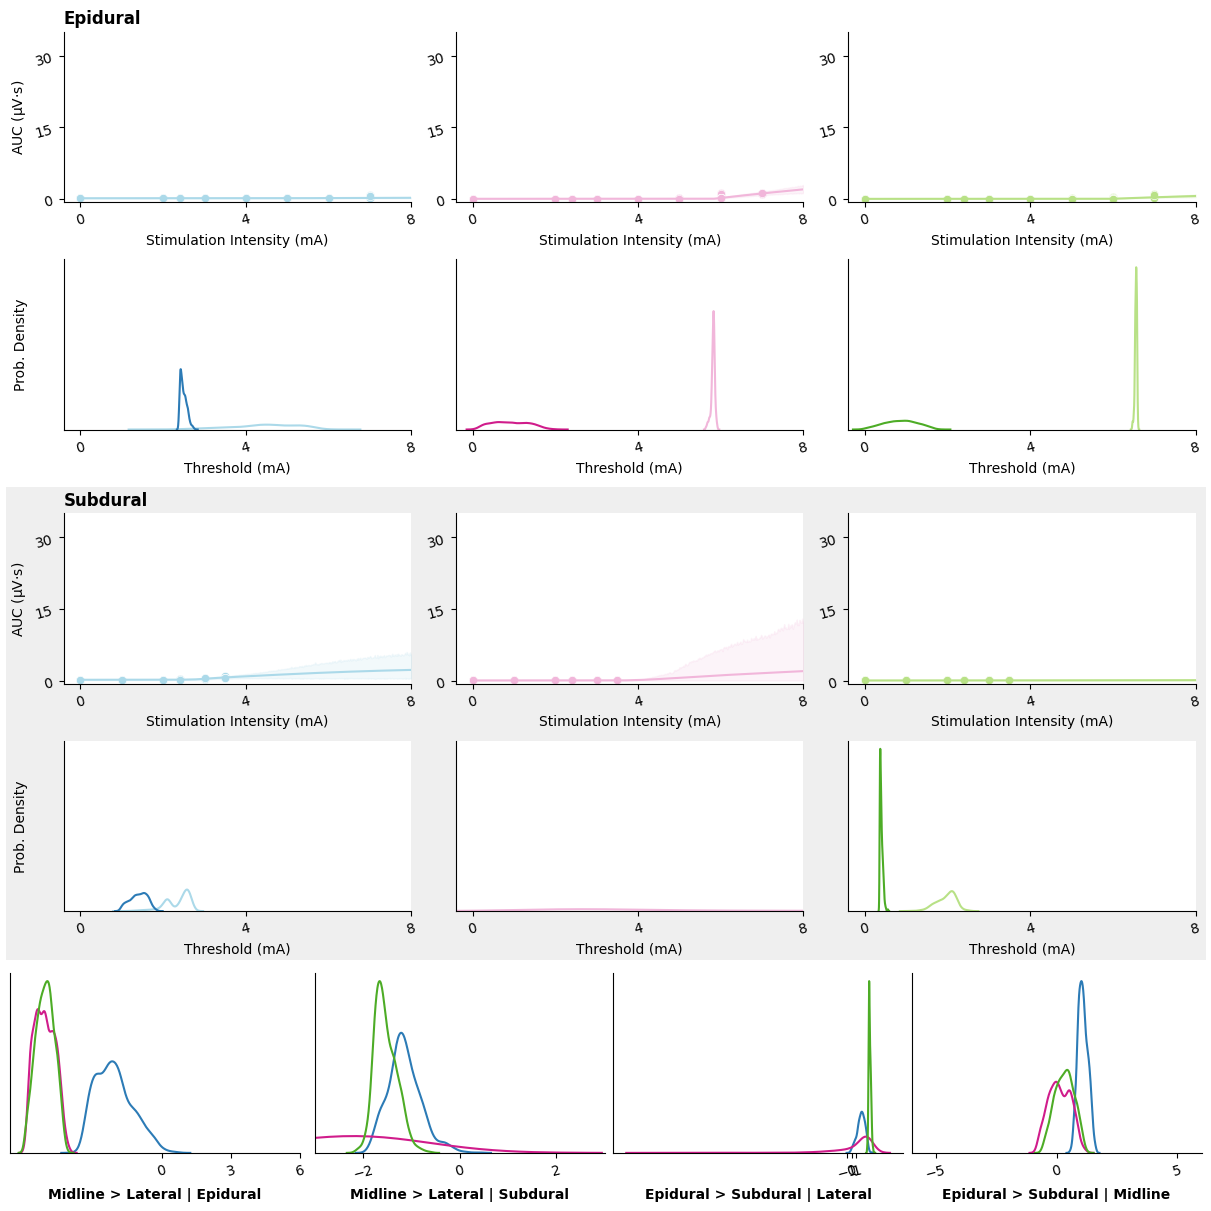

In [16]:
axis_label_size = 10
subdural_bgcolor = (.7, .7, .7, .2)

figure = plt.figure(figsize=(12, 12), constrained_layout=True)

(topfig, midfig, bottomfig) = figure.subfigures(3, 1, height_ratios=[1, 1, .5])

fig = topfig
topaxes = fig.subplots(2, 3, squeeze=False)

fig = midfig
midaxes = fig.subplots(2, 3, squeeze=False)
fig.set_facecolor(subdural_bgcolor)

fig = bottomfig
bottomaxes = fig.subplots(1, 4, squeeze=False)

allfigs = [topfig, midfig, bottomfig]
allaxes = [topaxes, midaxes, bottomaxes]

topaxes[0, 0].set_title("Epidural", fontweight="bold", loc="left")
midaxes[0, 0].set_title("Subdural", fontweight="bold", loc="left")

""" Epidural and Subdural"""
for depth in [0, 1]:
    fig = allfigs[depth]
    axes = allaxes[depth]

    for muscle_ind in range(model.n_response):
        for side in [0, 1]:
            c = (side, depth, 0)
            ind = df[model.features].apply(tuple, axis=1).isin([c])
            temp_df = df[ind].reset_index(drop=True).copy()

            pred_ind = prediction_df[model.features].apply(tuple, axis=1).isin([c])
            temp_pred_df = prediction_df[pred_ind].reset_index(drop=True).copy()
            temp_mu = mu[:, pred_ind, muscle_ind].mean(axis=0)
            temp_obs = obs[:, pred_ind, muscle_ind].mean(axis=0)
            temp_obs_hpdi = obs_hpdi[:, pred_ind, muscle_ind]

            ax = axes[0, muscle_ind]
            sns.scatterplot(x=temp_df[model.intensity], y=temp_df[model.response[muscle_ind]], color=response_colors[side][muscle_ind], ax=ax)
            sns.lineplot(x=temp_pred_df[model.intensity], y=temp_mu, color=response_colors[side][muscle_ind], ax=ax)
            # ax.axvline(x=a_adj[*c[::-1], muscle_ind], color=response_colors[side][muscle_ind], linestyle="--")
            ax.fill_between(
                temp_pred_df[model.intensity],
                temp_obs_hpdi[0, :],
                temp_obs_hpdi[1, :],
                color=response_colors[side][muscle_ind],
                alpha=.15
            )
            ax.sharex(topaxes[0, 0])
            ax.sharey(topaxes[0, 0])

            ax = axes[1, muscle_ind]
            sns.kdeplot(a[:, *c[::-1], muscle_ind] + a_kde_offset[*c[::-1], muscle_ind], color=response_colors[side][muscle_ind], ax=ax)
            # ax.axvline(x=a_adj[*c[::-1], muscle_ind], color=response_colors[side][muscle_ind], linestyle="--")
            ax.set_xlim(right=8)
            ax.sharex(axes[0, 0])
            ax.sharey(axes[1, 0])

for axes in allaxes:
    nrows, ncols = axes.shape
    for i in range(nrows):
        for j in range(ncols):
            ax = axes[i, j]
            sides = ['right', 'top']
            for side in sides:
                ax.spines[side].set_visible(False)
            ax.tick_params(
                axis='both',
                which='both',
                left=True,
                bottom=True,
                right=False,
                top=False,
                labelleft=True,
                labelbottom=True,
                labelright=False,
                labeltop=False,
                labelrotation=15
            )
            ax.set_xlabel("")
            ax.set_ylabel("")

for depth in [0, 1]:
    axes = allaxes[depth]
    ax = axes[0, 0]
    ax.set_xticks([0, 4, 8])
    ax.set_yticks([0, 15, 30])
    ax.set_ylabel("AUC (µV$\cdot$s)", size=axis_label_size)

    ax = axes[1, 0]
    ax.set_xticks([0, 4, 8])
    ax.set_ylabel("Prob. Density", size=axis_label_size)

    for muscle_ind in range(model.n_response):
        for side in [0, 1]:
            ax = axes[0, muscle_ind]
            ax.set_xlabel("Stimulation Intensity (mA)", size=axis_label_size)

            ax = axes[1, muscle_ind]
            ax.set_xlabel("Threshold (mA)", size=axis_label_size)
            ax.tick_params(
                axis='both',
                which='both',
                left=False,
                labelleft=False
            )

ax = topaxes[0, 0]
ax.set_ylim(top=35)

axes = bottomaxes
for muscle_ind in range(model.n_response):

    for depth, depth_name in [(0, "Epidural"), (1, "Subdural")]:
        ax = axes[0, depth]
        samples = a[:, 0, depth, 1, muscle_ind] - a[:, 0, depth, 0, muscle_ind]
        sns.kdeplot(samples, ax=ax, color=response_colors[1][muscle_ind])
        prob = (samples > 0).mean()
        # ax.set_title(f"Pr( Midline > Lateral | {depth_name} ) = {prob:.2f}", fontweight="bold")
        ax.set_xlabel(f"Midline > Lateral | {depth_name}", fontweight="bold")

    for side, side_name in [(0, "Lateral"), (1, "Midline")]:
        ax = axes[0, 2 + side]
        samples = a[:, 0, 0, side, muscle_ind] - a[:, 0, 1, side, muscle_ind]
        sns.kdeplot(samples, ax=ax, color=response_colors[1][muscle_ind])
        prob = (samples > 0).mean()
        # ax.set_title(f"Pr( Epidural > Subdural | {side_name} ) = {prob:.2f}", fontweight="bold")
        ax.set_xlabel(f"Epidural > Subdural | {side_name}", fontweight="bold")

ax = axes[0, 0]
ax.set_xticks([0, 3, 6])

ax = axes[0, 1]
ax.set_xlim(left=-3, right=3)
ax.set_xticks([-2, 0, 2])

ax = axes[0, 2]
ax.set_xticks([-1, 0, 1])

ax = axes[0, 3]
ax.set_xlim(left=-6, right=6)
ax.set_xticks([-5, 0, 5])

for j in range(4):
    ax = axes[0, j]
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
        labelleft=False
    )
    ax.set_ylabel("")

for fig in allfigs:
    fig.align_xlabels()
    fig.align_ylabels()

# dest = os.path.join(model.build_dir, "subdural-epidural.svg")
# figure.savefig(dest, dpi=600)

# dest = os.path.join(model.build_dir, "subdural-epidural.png")
dest = "/home/vishu/sub.png"
figure.savefig(dest, dpi=600)


In [90]:
model.combination_columns

['sc_laterality', 'sc_depth', 'participant']

In [89]:
a.shape

(4000, 1, 2, 2, 3)

In [19]:
dest

'/home/vishu/repos/hbmep-paper/reports/paper/figures/intraoperative/subdural-epidural/subdural-epidural.png'

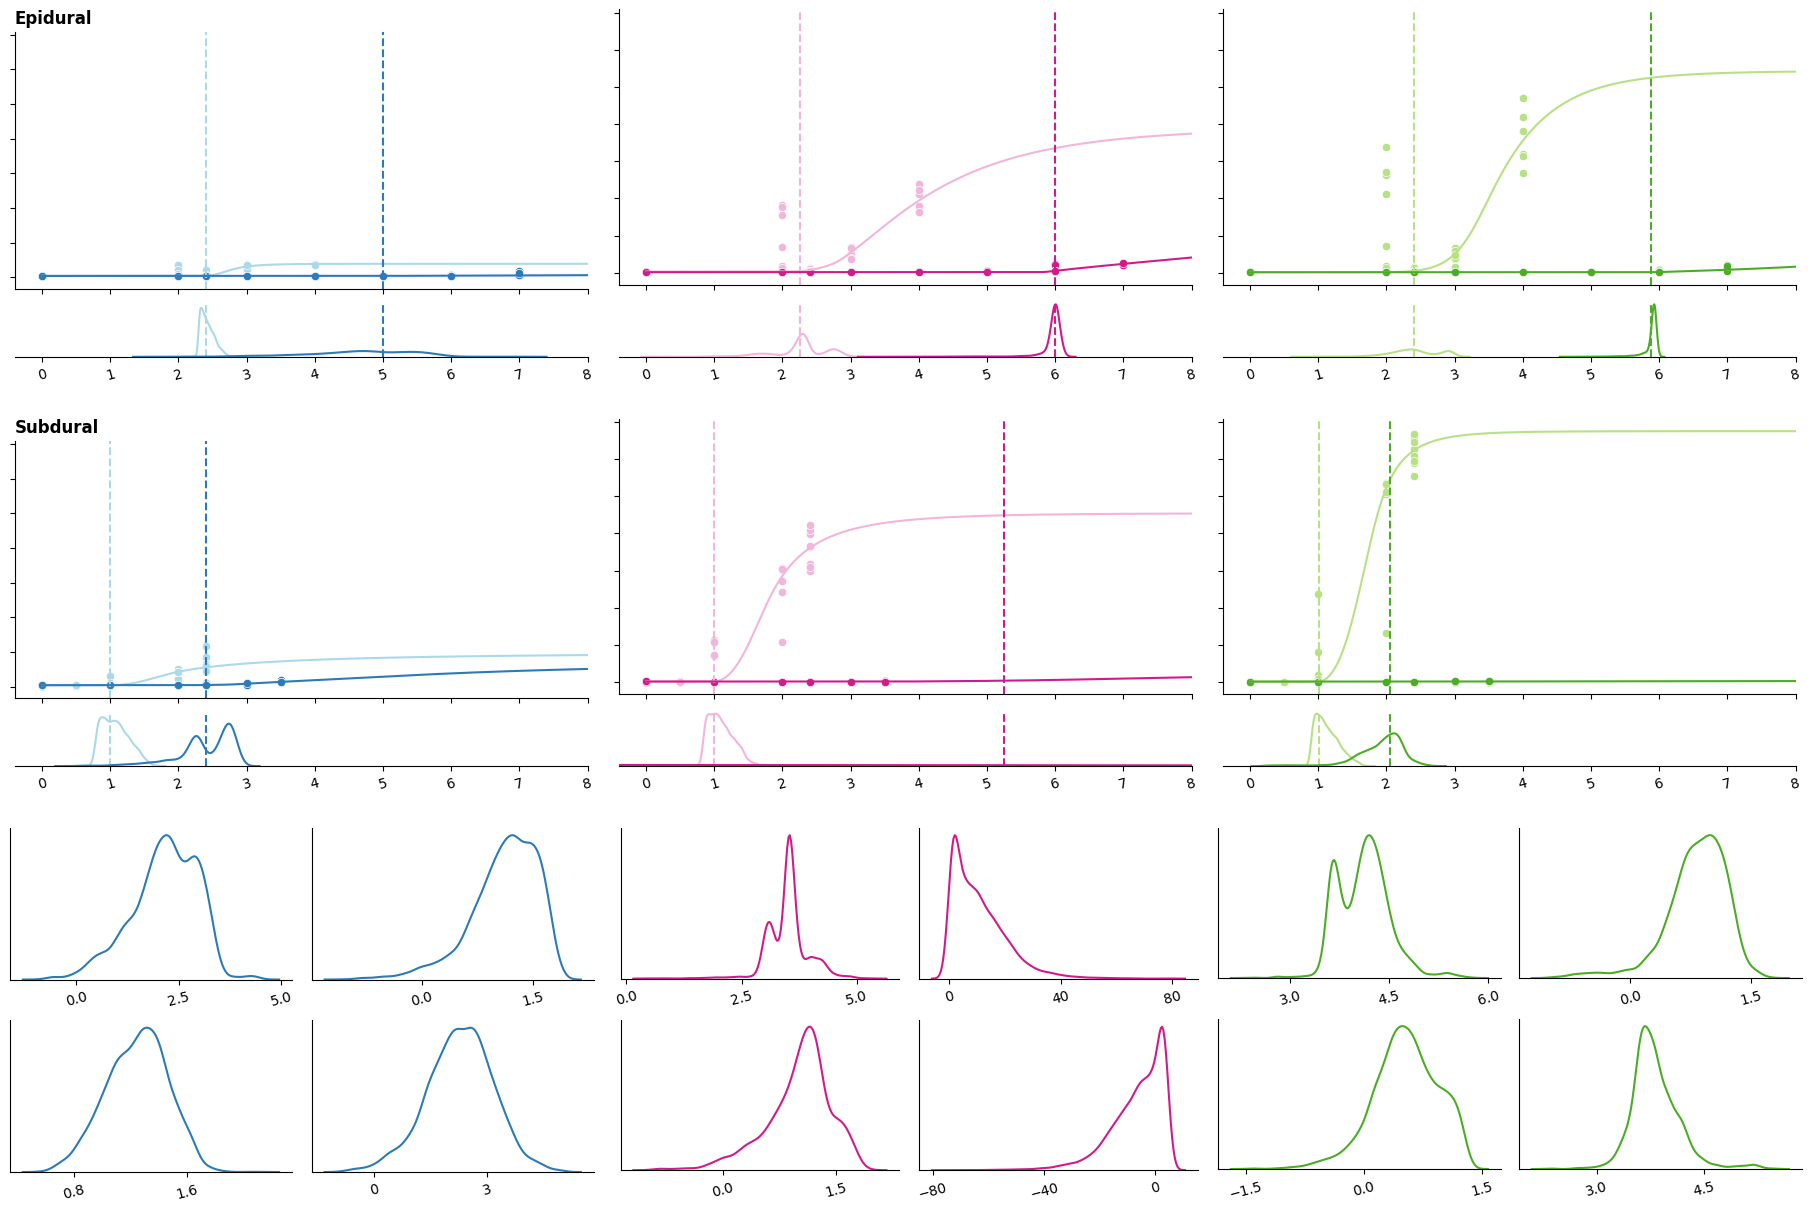

In [12]:
fig = plt.figure(figsize=(18, 12), constrained_layout=True)
subfigs = fig.subfigures(nrows=3, ncols=3, hspace=0.07, wspace=0.02)

main_axes = []
for i in range(2):
    arr = []
    for j in range(3):
        arr.append(subfigs[i, j].subplots(nrows=2, ncols=1, height_ratios=[1, .2], squeeze=False))
    main_axes.append(arr)

arr = []
for j in range(3):
    arr.append(subfigs[2, j].subplots(nrows=2, ncols=2, squeeze=False))
main_axes.append(arr)

# 0, 0
axes = main_axes[0][0]

for row in main_axes:
    for axes in row:
        for ax in axes.reshape(-1,):
            sides = ['right', 'top']
            for side in sides:
                ax.spines[side].set_visible(False)
            ax.tick_params(
                axis='both',
                which='both',
                left=True,
                bottom=True,
                right=False,
                top=False,
                labelleft=False,
                labelbottom=False,
                labelright=False,
                labeltop=False,
                labelrotation=15
            )
            ax.set_xlabel("")
            ax.set_ylabel("")

for depth in [0, 1]:
    for muscle_ind in range(model.n_response):
        axes = main_axes[depth][muscle_ind]
        ax = axes[1, 0]
        sides = ['left']
        for side in sides:
            ax.spines[side].set_visible(False)
        ax.tick_params(
            axis='both',
            which='both',
            left=False,
            labelbottom=True,
            labelrotation=15
        )
        ax.set_xticks([0, 4, 8])

# axes[0, 0].set_title("Epidural", loc="left")
""" Epidural and Subdural"""
for depth in [0, 1]:
    for muscle_ind in range(model.n_response):
        axes = main_axes[depth][muscle_ind]
        for side in [0, 1]:
            ax = axes[0, 0]

            c = (side, depth, 0)
            ind = df[model.combination_columns].apply(tuple, axis=1).isin([c])
            temp_df = df[ind].reset_index(drop=True).copy()
            sns.scatterplot(x=temp_df[model.intensity], y=temp_df[model.response[muscle_ind]], color=response_colors[side][muscle_ind], ax=ax)

            pred_ind = prediction_df[model.combination_columns].apply(tuple, axis=1).isin([c])
            temp_pred_df = prediction_df[pred_ind].reset_index(drop=True).copy()
            temp_mu = mu[:, pred_ind, muscle_ind].mean(axis=0)
            temp_obs = obs[:, pred_ind, muscle_ind].mean(axis=0)

            sns.lineplot(x=temp_pred_df[model.intensity], y=temp_mu, color=response_colors[side][muscle_ind], ax=ax)
            ax.axvline(x=a_adj[*c[::-1], muscle_ind], color=response_colors[side][muscle_ind], linestyle="--")

            ax.sharex(main_axes[0][0][0, 0])
            ax.sharey(main_axes[1][2][0, 0])

            ax = axes[1, 0]
            sns.kdeplot(a[:, *c[::-1], muscle_ind] + a_kde_offset[*c[::-1], muscle_ind], color=response_colors[side][muscle_ind], ax=ax)
            ax.axvline(x=a_adj[*c[::-1], muscle_ind], color=response_colors[side][muscle_ind], linestyle="--")
            ax.set_xlim(right=8)
            ax.sharex(axes[0, 0])

ax = main_axes[0][0][0, 0]
ax.set_title("Epidural", loc="left", fontweight="bold")

ax = main_axes[1][0][0, 0]
ax.set_title("Subdural", loc="left", fontweight="bold")

""" Summary """
for muscle_ind in range(model.n_response):
    axes = main_axes[2][muscle_ind]
    for j in range(2):
        ax = axes[0, j]
        samples = a[:, 0, j, 1, muscle_ind] - a[:, 0, j, 0, muscle_ind]
        sns.kdeplot(samples, ax=ax, color=response_colors[1][muscle_ind])
        prob = (samples > 0).mean()
        # if j == 0: title = f"Pr (Midline > Lateral | Epidural) = {prob:.2f}"
        # if j == 1: title = f"Pr (Midline > Lateral | Subdural) = {prob:.2f}"
        if j == 0: title = f"Midline - Lateral | Epidural"
        if j == 1: title = f"Midline - Lateral | Subdural"
        ax.set_xlabel(title)
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))
        ax.yaxis.set_major_locator(plt.MaxNLocator(3))
        ax.tick_params(
            axis='both',
            which='both',
            # labelleft=True,
            left=False,
            labelbottom=True,
            labelrotation=15
        )

    for j in range(2):
        ax = axes[1, j]
        samples = a[:, 0, 0, j, muscle_ind] - a[:, 0, 1, j, muscle_ind]
        sns.kdeplot(samples, ax=ax, color=response_colors[1][muscle_ind])
        prob = (samples > 0).mean()
        # if j == 0: title = f"$Pr ($Epidural > Subdural | Lateral$) = ${prob:.2f}"
        # if j == 1: title = f"$Pr ($Epidural > Subdural | Midline$) = ${prob:.2f}"
        if j == 0: title = f"Epidural - Subdural | Lateral"
        if j == 1: title = f"Epidural - Subdural | Midline"
        ax.set_xlabel(title)
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))
        ax.yaxis.set_major_locator(plt.MaxNLocator(3))
        ax.tick_params(
            axis='both',
            which='both',
            # labelleft=True,
            left=False,
            labelbottom=True,
            labelrotation=15
        )

dest = os.path.join(model.build_dir, "subdural-epidural.png")
fig.savefig(dest, dpi=600)


In [300]:
a.shape

(4000, 1, 2, 2, 3)

In [301]:
model.combination_columns[::-1]

['participant', 'sc_depth', 'sc_laterality']

array([4.45735614, 4.47793352, 4.12634295, ..., 3.95003155, 3.82860409,
       3.57473768])

In [ ]:
sns.kdeplot()

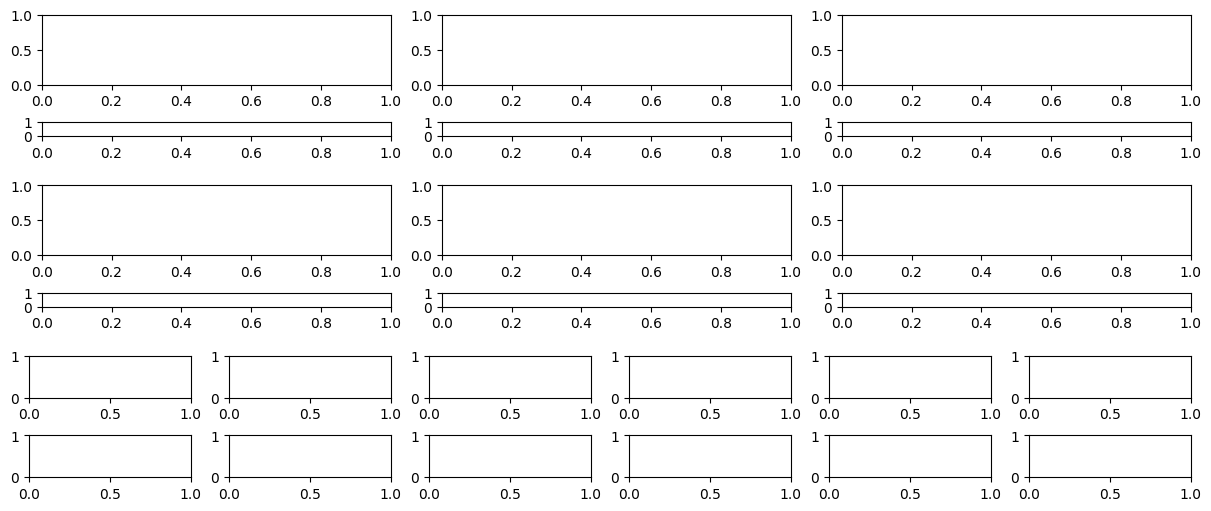

In [220]:
fig = plt.figure(figsize=(12, 5), constrained_layout=True)
subfigs = fig.subfigures(nrows=3, ncols=1, hspace=0.07)

axes = subfigs[0].subplots(nrows=2, ncols=3, height_ratios=[1, .2], squeeze=False)
axes = subfigs[1].subplots(nrows=2, ncols=3, height_ratios=[1, .2], squeeze=False)
axes = subfigs[2].subplots(nrows=2, ncols=6, squeeze=False)


In [7]:
c = (7, 0)

ind = df[model.combination_columns[::-1]].apply(tuple, axis=1).isin([c])
temp_df = df[ind].reset_index(drop=True).copy()



In [8]:
a = posterior_samples[site.a]
a.shape

(4000, 13, 2, 1)

In [9]:
a_map = a.mean(axis=0)
a_map.shape


(13, 2, 1)

In [10]:
mu = posterior_predictive[site.mu]
obs = posterior_predictive[site.obs]


In [11]:
from numpyro.diagnostics import hpdi

obs_hpdi = hpdi(obs, prob=.95)
obs_hpdi.shape


(2, 52000, 1)

In [12]:
a_random_mean = posterior_samples["a_random_mean"].reshape(-1,)
a_random_mean.shape


(4000,)

In [13]:
def fn_prime(x, *args):
    grad = jax.grad(model.fn, argnums=0)
    for _ in range(len(x.shape)):
        grad = jax.vmap(grad)
    return grad(x, *args)


In [14]:
a, b, v, ell, L, H = \
    np.array(posterior_samples[site.a]), np.array(posterior_samples[site.b]), np.array(posterior_samples[site.v]), np.array(posterior_samples["ell"]), np.array(posterior_samples[site.L]), np.array(posterior_samples[site.H])

(subject, n_subject), (features, n_features), (intensity, n_data), = model._collect_regressor(df=prediction_df)
intensity = intensity.reshape(-1, 1)
intensity = np.tile(intensity, (a.shape[0], 1, model.n_response))
feature0 = features[0].reshape(-1,)

params = [a, b, v, ell, L, H]
params = [u[:, subject, feature0] for u in params]

fn_prime_out = fn_prime(intensity, *params)
fn_prime_out = np.array(fn_prime_out)

fn_prime_out.shape


(4000, 52000, 1)

In [63]:
temp_fn_prime_out.shape

(4000, 2000)

In [50]:
a_random = posterior_samples["a_random"][..., 0, 0]
a_random.shape

(4000, 13)

/tmp/ipykernel_224127/1493889291.py:121: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_yticklabels([0., .5, 1.])


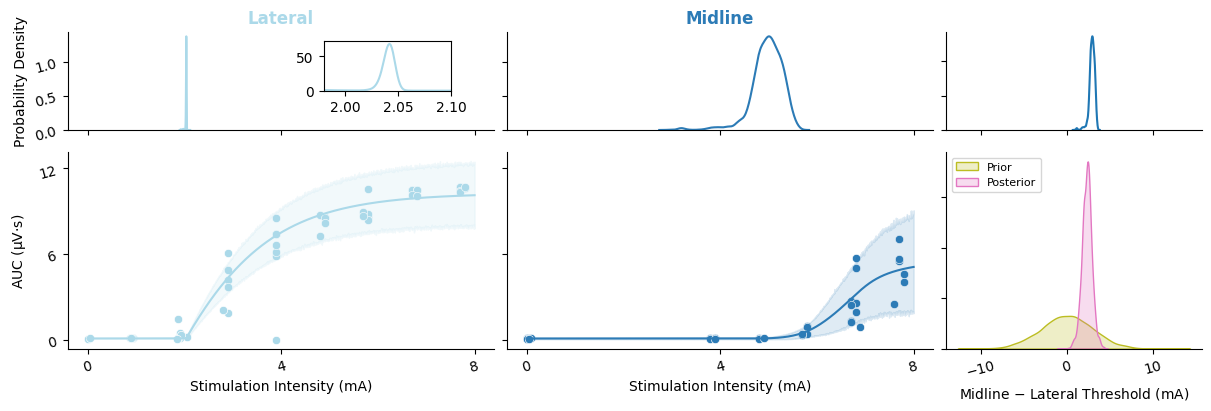

In [55]:
response_colors = [(0.6706, 0.8510, 0.9137), (0.1725, 0.4824, 0.7137)]
subject = 7
cmap = sns.color_palette("tab10")

nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 2 * nrows), squeeze=False, constrained_layout=True, height_ratios=[.5, 1], width_ratios=[1, 1, .6])

counter = 0
for _ in range(nrows * ncols):
    i, j = counter // ncols, counter % ncols
    c = (subject, j)
    ax = axes[i, j]

    if i == 0 and j in {0, 1}: # Thresholds
        sns.kdeplot(a[:, *c, 0], ax=ax, color=response_colors[j])
        if j == 0:
            ins = ax.inset_axes([0.6,0.4,0.3,0.5])
            sns.kdeplot(a[:, *c, 0], ax=ins, color=response_colors[j])
            ins.set_xlabel("")
            ins.set_ylabel("")
            ins.set_xlim(left=1.98, right=2.1)
            ins.set_ylim(bottom=-.03)

        # temp_fn_prime_out = fn_prime_out[:, pred_ind, 0]
        # max_grad = temp_fn_prime_out.max(axis=-1)
        # sns.kdeplot(max_grad, ax=axes[i, 2])

    if i == 1 and j in {0, 1}:
        ind = df[model.combination_columns[::-1]].apply(tuple, axis=1).isin([c])
        temp_df = df[ind].reset_index(drop=True).copy()

        pred_ind = prediction_df[model.combination_columns[::-1]].apply(tuple, axis=1).isin([c])
        temp_pred_df = prediction_df[pred_ind].reset_index(drop=True).copy()

        temp_obs = obs[:, pred_ind, 0]
        temp_mu = mu[:, pred_ind, 0]
        temp_obs_hpdi = obs_hpdi[:, pred_ind, 0]

        sns.scatterplot(x=temp_df[model.intensity], y=temp_df[model.response[0]], ax=ax, color=response_colors[j])
        # sns.lineplot(x=temp_pred_df[model.intensity], y=temp_obs.mean(axis=0), ax=ax)
        sns.lineplot(x=temp_pred_df[model.intensity], y=temp_mu.mean(axis=0), color=response_colors[j], ax=ax)
        ax.fill_between(
            temp_pred_df[model.intensity],
            temp_obs_hpdi[0, :],
            temp_obs_hpdi[1, :],
            color=response_colors[j],
            alpha=.15
        )

    if i == 0 and j == 2:
        ax = axes[i, j]
        # sns.kdeplot(a[:, subject, 1, 0] - a[:, subject, 0, 0], ax=ax)
        sns.kdeplot(a_random[:, subject], ax=ax)

    if i == 1 and j == 2:
        d = dist.Normal(0, 3)
        prior = d.sample(model.rng_key, (10000, ))
        sns.kdeplot(prior, ax=ax, color=cmap[-2], fill=True, label="Prior")
        sns.kdeplot(a_random_mean, ax=ax, color=cmap[6], fill=True, label="Posterior")

    counter += 1

# gs = axes[0, 2].get_gridspec()
# for ax in axes[:, -1]:
#     ax.remove()
# axbig = fig.add_subplot(gs[:, -1])
# ax = axbig
# d = dist.Normal(0, 3)
# prior = d.sample(model.rng_key, (10000, ))
# sns.kdeplot(prior, color=cmap[-2], fill=True, label="Prior", ax=ax)
# sns.kdeplot(a_random_mean, color=cmap[6], fill=True, label="Posterior", ax=ax)
# ax.legend(loc="upper left")

axes[0, 0].sharex(axes[1, 0])
axes[0, 1].sharex(axes[1, 0])
axes[1, 1].sharex(axes[1, 0])

axes[0, 2].sharex(axes[1, 2])

# axes[0, 1].sharey(axes[0, 0])
axes[1, 1].sharey(axes[1, 0])

axes[1, 2].legend(loc="upper left", prop = { "size": 8 })

subset = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
for i, j in subset:
    ax = axes[i, j]
    sides = ['right', 'top']
    for side in sides:
        ax.spines[side].set_visible(False)
    ax.tick_params(
        axis='both',
        which='both',
        left=True,
        bottom=True,
        right=False,
        top=False,
        labelleft=False,
        labelbottom=False,
        labelright=False,
        labeltop=False,
        labelrotation=15
    )
    if j == 0:
        ax.tick_params(
            axis='both',
            which='both',
            labelleft=True,
            labelrotation=15
        )
    if i == 1:
        ax.tick_params(
            axis='both',
            which='both',
            labelbottom=True,
            labelrotation=15
        )

# axes[0, 0].set_ylim(bottom=-2)
# axes[0, 1].sharey(axes[0, 0])
axes[0, 0].set_yticklabels([0., .5, 1.])

axes[1, 0].set_yticks([0, 6, 12])
axes[1, 0].set_xticks([0, 4, 8])

axes[1, 2].set_xticks([-10, 0, 10])

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        ax.set_xlabel("")
        ax.set_ylabel("")

axis_label_size = 10
axes[0, 0].set_ylabel("Probability Density", size=axis_label_size)

axes[1, 0].set_ylabel("AUC (µV$\cdot$s)", size=axis_label_size)
axes[1, 0].set_xlabel("Stimulation Intensity (mA)", size=axis_label_size)
axes[1, 1].set_xlabel("Stimulation Intensity (mA)", size=axis_label_size)

axes[1, 2].set_xlabel("Midline $-$ Lateral Threshold (mA)")

axes[0, 0].set_title("Lateral", fontweight="bold", color=response_colors[0])
axes[0, 1].set_title("Midline", fontweight="bold", color=response_colors[1])

# axes[0, 0].set_title("Lateral", fontweight="bold", color=response_colors[0])
# axes[0, 1].set_title("Midline", fontweight="bold", color=response_colors[1])

fig.align_ylabels()

dest = os.path.join(model.build_dir, "midline-lateral.png")
fig.savefig(dest, dpi=600)


In [58]:
dest

'/home/vishu/repos/hbmep-paper/reports/paper/figures/intraoperative/midline-lateral/midline-lateral.png'